## Mirando la equidad por género

### Mirando matriz de confusión y métricas varias

Ahora vamos a analizar al atributo que consideramos sensible en este análisis, el género. Para esto voy a separar el conjunto de datos de test entre la categoría femenina y masculina, además de que voy a quedarme solo con las columnas relevantes para esta evaluación:

In [ ]:
fairness_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
    'genre': df_legible.loc[idx_test, 'genre']
})

In [ ]:
fairness_df

,y_test,y_pred,genre
521,1,1,female
737,0,1,male
740,0,1,male
660,0,0,male
411,0,0,male
...,...,...,...
408,0,0,male
332,1,1,female
208,0,1,male
613,0,0,female


In [ ]:
fairness_df_male = fairness_df[fairness_df['genre'] == 'male']
fairness_df_female = fairness_df[fairness_df['genre']  == 'female']

Con los grupos separados lo siguiente es armar una matriz de confusión para cada uno, así podremos tener insights más precisos sobre el comportamiento del modelo con ambos grupos:

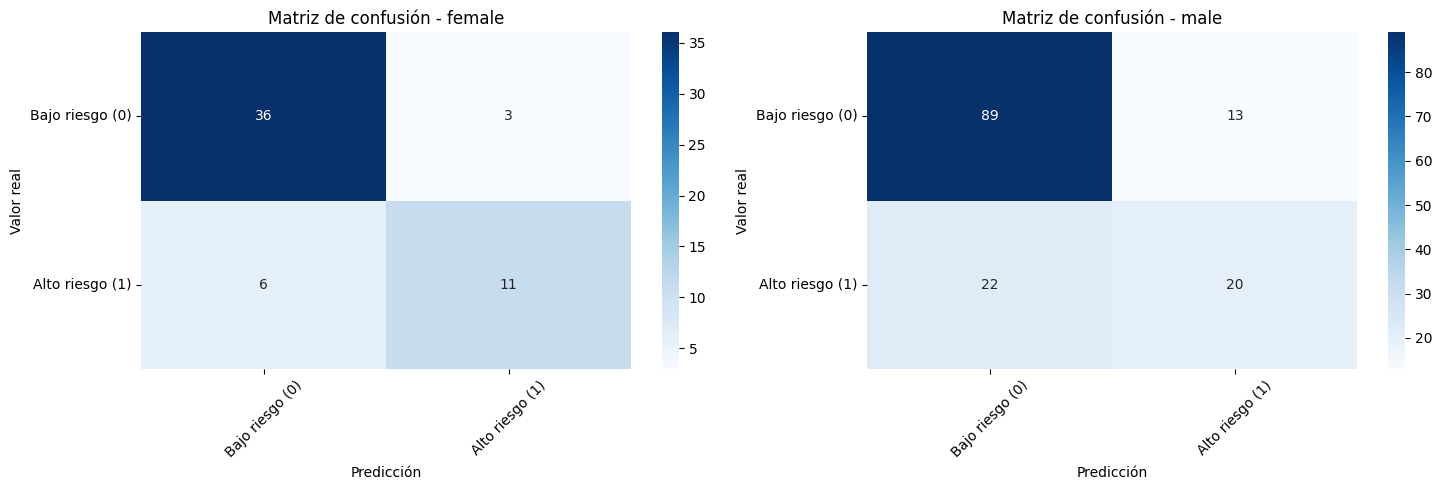

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

dfs = [fairness_df_female, fairness_df_male]

for ax, df in zip(axes, dfs):
    cm = confusion_matrix(df['y_test'], df['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Valor real')
    ax.set_title(f'Matriz de confusión - {df["genre"].iloc[0]}')
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels, rotation=0)
plt.tight_layout()

De este par de gráficos podemos notar lo siguiente:

* En ambas categorías el modelo logró identificar en la mayoría de los casos a los verdaderos positivos con 36 casos en la categoría femenina y 89 en la masculina.

* En la categoría masculina se obtuvo una mayor tasa de falsos positivos en términos de proporción a comparación de la categoría femenina, siendo que de un total de 42 casos de alto riesgo, 22 fueron falsos positivos y 20 verdaderos negativos.

* En la categoría femenina solamente se identificaron a 3 personas erróneamente como de alto riesgo, lo que indica que el modelo tuvo un buen desempeño identificando instancias positivas en esta clase.

Con estos puntos ya empezamos a notar cosas importantes acerca del desempeño del modelo entre los grupos, pareciendo inicialmente que el modelo se desempeñó mejor en la clase femenina.

Miremos ahora las métricas generales de clasificación para cada grupo:

In [ ]:
print("Mujeres:")
print(classification_report(fairness_df_female['y_test'], fairness_df_female['y_pred']))
print("Hombres:")
print(classification_report(fairness_df_male['y_test'], fairness_df_male['y_pred']))

Mujeres:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        39
           1       0.79      0.65      0.71        17

    accuracy                           0.84        56
   macro avg       0.82      0.79      0.80        56
weighted avg       0.84      0.84      0.83        56

Hombres:
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       102
           1       0.61      0.48      0.53        42

    accuracy                           0.76       144
   macro avg       0.70      0.67      0.68       144
weighted avg       0.74      0.76      0.75       144



Podemos confirmar eso que vimos en las matrices de confusión: el modelo tuvo un mejor desempeño en la categoría femenina que en la masculina. Podemos ver que en cada métrica que presenta este reporte la categoría femenina superó a la categoría masculina a pesar de que esta última es la que presenta en mayor proporción entre nuestros datos. ¿Será esto una señal de inequidad o sesgo?.

Para analizar esto aún más a profundidad vamos a utilizar una herramienta especializada en este ámbito y esa es la librería [Aequitas](https://github.com/dssg/aequitas) que ofrece una gran cantidad de módulos y funciones que facilitan el análisis de equidad y permiten ir más allá de las métricas que discutimos hasta ahora.

### Usando Aequitas

Para empezar a usar Aequitas primero tenemos que verificar que esté instalada e importar los módulos que vamos a usar:

In [ ]:
!pip install aequitas

In [ ]:
from aequitas.fairness import Fairness
import aequitas.plot as ap
from aequitas.plotting import Plot
from aequitas.group import Group
from aequitas.bias import Bias

Para trabajar con Aequitas este nos pide algunos requisitos en los nombres de las columnas:

* La columna que contiene a los valores reales de la variable objetivo se debe llamar 'label_value'.

* La columna que contiene a los valores predichos por el modelo se debe llamar
'score'.

Con esto dicho procedo a cambiar los nombres de las columnas:

In [ ]:
fairness_df_aequitas = fairness_df.rename(columns={
    'y_test': 'label_value',
    'y_pred': 'score'
})

Entre los módulos que importamos está la clase "Group" la cual permite evaluar sesgos a través de todos los grupos que definimos en nuestros datos, para este caso los grupos los dicta la variable que registra el género.

Lo que hace para lograr este análisis de sesgo es algo similar a lo que hicimos en la sección anterior: crear una matriz de confusión para cada grupo y a partir de ahí calcular diferentes métricas.

Más específicamente el método 'get_crosstabs(df)' es el encargado de obtener la matriz de confusión y separa las métricas calculadas en 2 grupos principales: Conteos de grupo y Métricas absolutas.

In [ ]:
g = Group()
xtab, _ = g.get_crosstabs(fairness_df_aequitas)

# Obtengo las métricas absolutas
absolute_metrics = g.list_absolute_metrics(xtab)

El método 'list_absolute_metrics()' justamente retorna una lista con los nombres de las métricas absolutas, el resto que no incluye son los conteos. A continuación dejo un par de tablas que explican el contenido de ambos tipos de métricas:


#### Conteos de grupo calculados:

| Tipo de conteo | Nombre Columna |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' |
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

#### Métricas absolutas calculadas:

| Métrica | Nombre Columna |
| --- | --- |
| True Positive Rate | 'tpr' |
| True Negative Rate | 'tnr' |
| False Omission Rate | 'for' |
| False Discovery Rate | 'fdr' |
| False Positive Rate | 'fpr' |
| False Negative Rate | 'fnr' |
| Negative Predictive Value | 'npv' |
| Precision | 'precision' |
| Predicted Positive Ratio$_k$ | 'ppr' |
| Predicted Positive Ratio$_g$ | 'pprev' |
| Group Prevalence | 'prev' |

A continuación voy a usar la 'xtab' que obtuvimos antes para ver estas métricas en nuestro caso particular:

In [ ]:
xtab[['attribute_value'] + absolute_metrics]

,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,female,0.839286,0.647059,0.923077,0.142857,0.214286,0.076923,0.352941,0.857143,0.785714,0.297872,0.250000,0.303571
1,male,0.756944,0.476190,0.872549,0.198198,0.393939,0.127451,0.523810,0.801802,0.606061,0.702128,0.229167,0.291667


In [ ]:
xtab[[col for col in xtab.columns if col not in absolute_metrics + ['model_id', 'score_threshold', 'k', 'attribute_name']]]

,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,female,14,42,3,6,36,11,17,39,56,200
1,male,33,111,13,22,89,20,42,102,144,200


Bueno dados los valores que observamos podemos notar que consideró como clase positiva al 1 = cliente de alto riesgo crediticio, lo cual debemos considerar al interpretar a los valores de las métricas absolutas. Sin embargo sus valores en los conteos de grupo coinciden con lo que vimos anteriormente en la matriz de confusión que hicimos antes.

Para hacer un análisis un poco más visual de lo que representan estas métricas podemos generar gráficos:

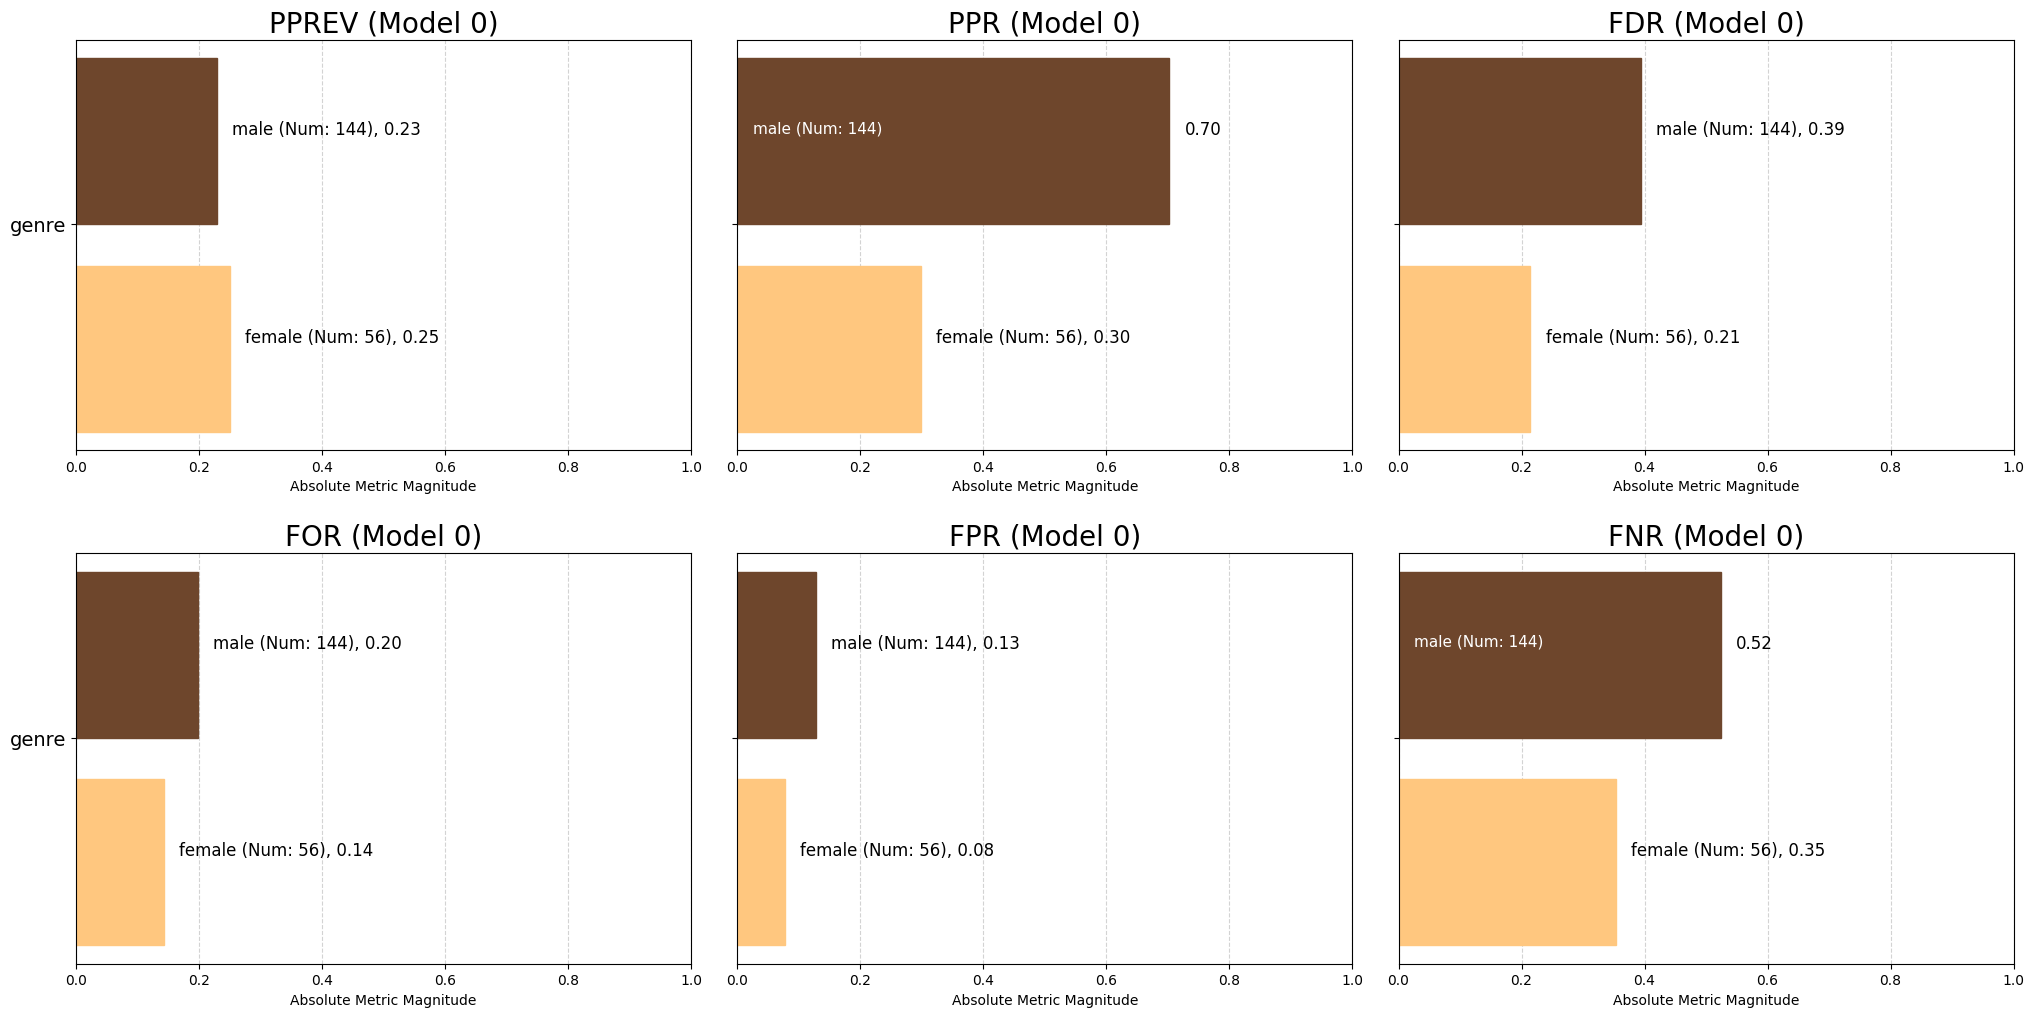

<Figure size 640x480 with 0 Axes>

In [ ]:
aqp = Plot()
a = aqp.plot_group_metric_all(xtab, ncols=3)
plt.tight_layout()

Este gráfico muestra la comparativa entre los grupos de algunas métricas absolutas, las consideradas por la librería como "default".

Podemos notar algo que vimos también en el resumen de clasificación en la sección anterior, y es que el modelo tuvo mejor desempeño en cada métrica para el grupo femenino a comparación del masculino. Un ejemplo es el False Negative Rate donde la diferencia es bastante pronunciada, siendo el grupo masculino el que cuenta con 0.52 de proporción y el grupo femenino solo con 0.35.

### Evaluando según distintos enfoques del Group Fairness

Desde el principio de este análisis hemos estado analizando el riesgo crediticio de un solicitante tomando como atributo protegido a la variable que registra el género del mismo, por lo tanto podemos considerar que estamos haciendo un análisis de equidad por grupos.

Justamente una de las ramas del Fairness en aprendizaje automático que ofrece formas de medir equidad en grupos es el "Group Fairness", el cual ofrece consigo 4 principales definiciones de lo que podríamos considerar como equidad según nuestro criterio:

* **Statistical Parity:** Evalúa si un modelo de clasificación selecciona o aprueba personas en igual proporción entre distintos grupos, sin importar si realmente cumplen o no con los criterios para ser seleccionados.

* **Equalized Odds**: Exige que el modelo cometa aciertos y errores con la misma frecuencia en todos los grupos. Es decir, quienes merecen ser clasificados positivamente deberían tener la misma probabilidad de serlo (true positive rate), y quienes no lo merecen deberían tener la misma probabilidad de ser incorrectamente clasificados como positivos (false positive rate), sin importar a qué grupo pertenezcan.

* **Equal Opportunity**: Se enfoca únicamente en los casos en los que las personas realmente merecen ser clasificadas como positivas (true positive rate), y exige que el modelo les dé las mismas oportunidades de ser seleccionadas, sin importar su grupo.

* **Predictive Parity**: Evalúa si, entre todos los que fueron clasificados como positivos por el modelo, la probabilidad de que realmente lo sean (es decir, que sí lo merecían) es la misma para todos los grupos. En otras palabras, si el modelo dice que una persona de cierto grupo merece un beneficio, esta métrica se asegura de que esa predicción tenga la misma fiabilidad que para alguien de otro grupo.


Normalmente al trabajar con Group Fairness elegimos la definición que más se adapte a nuestro caso y trabajamos con ella, pero a casos prácticos de este análisis vamos a hacer un análisis de Fairness considerando a las 4 definiciones.

Para eso vamos a utilizar otra clase que ofrece Aequitas la cual se llama "Bias" y sirve para estimar disparidades entre diferentes grupos en nuestros datos. Para calcular dichas disparidades usa como base las métricas que obtuvimos anteriormente usando la clase "Group" y luego calcula la disparidad correspondiente a cada métrica haciendo el siguiente cociente:

$$Disparidad_{métrica} = \frac{Métrica_{grupoA}}{Métrica_{grupoB}}$$

Donde "grupoB" sería ese grupo que consideramos como "base" y "grupoA" un grupo que nos interesa medir respecto del base. No está de más decir que si no hay disparidad entonces este cociente sea la métrica que sea debería ser casi igual a 1.

In [ ]:
b = Bias()
bias = b.get_disparity_predefined_groups(
    xtab,
    original_df=fairness_df_aequitas,
    ref_groups_dict={'genre': 'male'},
    alpha=0.05,
    mask_significance=True
)

f = Fairness()
fairness = f.get_group_value_fairness(bias)

En el código de arriba usamos "Bias" para calcular las diparidades y dicho resultado se añade a la 'xtab' que estabámos usando anteriormente. Además hacemos uso de una nueva clase "Fairness" que usa las disparidades para afirmar o no la inequidad entre los grupos.

A continuación vamos a ver la estructura del conjunto de datos "fairness" que obtuvimos:

In [ ]:
fairness

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,...,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,47,genre,female,0.839286,0.647059,0.923077,0.142857,0.214286,...,False,False,True,True,False,False,False,False,False,False
1,0,binary 0/1,47,genre,male,0.756944,0.476190,0.872549,0.198198,0.393939,...,True,True,True,True,True,True,True,True,True,True


Podemos ver que efectivamente es el mismo conjunto de datos que antes pero añadiendo al final los nuevos cálculos que ofrecen las clases "Fairness" y "Bias" respectivamente.

Como ahora nos estamos enfocando en las disparidades vamos a observar a las mismas en nuestro conjunto de datos:

In [ ]:
calculated_disparities = b.list_disparities(fairness)
fairness[['attribute_value'] + calculated_disparities]

,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,female,0.424242,1.090909,1.296429,0.543956,0.720779,0.60355,0.673797,1.358824,1.057908,1.069021
1,male,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


Podemos ver que para la clase base "male" la disparidad siempre da 1, tiene sentido ya que una clase siempre es similar a ella misma. Luego para la clase "female" vemos que los valores son diferentes en cada caso y estos representan las disparidades que queremos medir.

Normalmente lo que hacemos es definir un umbral de equidad y a partir de ahí decidir si una clase obtuvo clasificaciones justas o no, en ambos sentidos. Un valor habitual para este umbral puede ser 1.25, este lo que haría sería considerar injusto aquellos valores de disparidad en la clase de interés que estén por fuera del rango [1 - 0.25, 1 + 0.25].

Ahora para terminar este análisis de equidad por género vamos a utilizar todas estas métricas calculadas anteriormente y evaluar si nuestro modelo de clasificiación cumple con las definiciones de Fairness que discutimos al principio. Vamos a darle un sentido a cada definición según el contexto de nuestro caso y mirar mediante gráficos que ocurre en cada caso.

**Statistical Parity / Demographic Parity (Independencia): $\mathbb{P}(\hat{Y} = 1 | A =a) = \mathbb{P}(\hat{Y} = 1 | A =b)$**

En nuestro caso tenemos que la clase positiva es 1 = solicitante de alto riesgo crediticio. Tomando en cuenta eso podemos decir que Statistical Parity busca que la tasa de solicitantes clasificados **por el modelo** como de alto riesgo sea la misma para ambos géneros.

Una métrica que nos podría ayudar es 'pprev' que según la [documentación de Aequitas](https://dssg.github.io/aequitas/metrics.html) mide la proporción de instancias identificadas como positivas por el modelo (en nuestro caso solicitantes de alto riesgo) sobre el total de instancias para un grupo dado, lo cual justamente coincide con la definición de probabilidad condicional más arriba.

In [ ]:
metrics = ['pprev']

print('Evaluando Statistical Parity/Demographic Parity')
ap.summary(fairness, metrics, fairness_threshold = 1.25)

Evaluando Statistical Parity/Demographic Parity


alt.VConcatChart(...)

In [ ]:
ap.disparity(fairness, metrics, 'genre' ,fairness_threshold = 1.25)

alt.LayerChart(...)

**Equalized Odds (Separación): $\mathbb{P}(\hat{Y} = 1 |Y = 1, A =a) = \mathbb{P}(\hat{Y} = 1 |Y = 1, A =b)$ $\text{ y }$ $\mathbb{P}(\hat{Y} = 1 |Y = 0, A =a) = \mathbb{P}(\hat{Y} = 1 |Y = 0, A =b)$**

Para Equalized Odds tenemos que esta métrica busca que **el modelo** clasifique como solicitantes de alto riesgo correcta e incorrectamente a ambos géneros por igual. Esto implica que ambos grupos tendrían la misma probabilidad de recibir predicciones positivas (alto riesgo en nuestro caso) verdaderas y falsas.

**Equal Oportunity (Separación relajada): $\mathbb{P}(\hat{Y} = 1 |Y = 1, A =a) = \mathbb{P}(\hat{Y} = 1 |Y = 1, A =b)$**

Equal Oportunity es una versión "relajada" del caso anterior, esta solo busca que **el modelo** ofrezca la misma tasa de solicitantes clasificados como de alto riesgo **correctamente** para ambos géneros.

En este caso las métricas que nos van a ayudar son más claras, el True Positive Rate y el False Positive Rate. Para que se cumpla Equalized Odds ambas métricas deberían pasar la prueba de disparidad y para que se cumpla Equal Oportunity solo basta con que el true positive rate lo haga.

In [ ]:
metrics = ['tpr', 'fpr']

print('Evaluando Equalized Odds y Equal Opportunity')
ap.summary(fairness, metrics, fairness_threshold = 1.25)

Evaluando Equalized Odds y Equal Opportunity


alt.VConcatChart(...)

In [ ]:
ap.disparity(fairness, metrics, 'genre' ,fairness_threshold = 1.25)

alt.LayerChart(...)

**Predictive Parity (Suficiencia): $\mathbb{P}(Y= 1 |\hat{Y} =\hat{y}, A =a) = \mathbb{P}(Y= 1 |\hat{Y} =\hat{y}, A =b)$**  

Predictive Parity es una métrica que trabaja más sobre las clasificaciones reales. Para nuestro caso esta lo que busca es que ambos géneros tengan la misma probabilidad de que cuando fueron identificados como solicitantes de alto riesgo **por el modelo** estos realmente lo sean en la realidad.

Una métrica que nos sirve en este caso es la precisión, que lo que hace es que basándose en todas las predicciones del modelo mira cuáles fueron positivas (solicitantes de alto riesgo) realmente.

In [ ]:
metrics = ['precision']

print('Evaluando Predictive Parity')
ap.summary(fairness, metrics, fairness_threshold = 1.25)

Evaluando Predictive Parity


alt.VConcatChart(...)

In [ ]:
ap.disparity(fairness, metrics, 'genre' ,fairness_threshold = 1.25)

alt.LayerChart(...)

Tenemos que para un umbral de 1.25 de disparidad y tomando como categoría base al género masculino la única métrica que "pasó la prueba" fue Statistical Parity/Demographic Parity, luego el resto no lograron pasar esta prueba pero sin embargo hay varias cosas que podemos notar:

* El False Positive rate del género femenino dió mucho más bajo que el del género masculino, acercándose a casi 2 puntos de disparidad. Esto implica de que el modelo tiende a clasificar erronéamente como solicitante de alto riesgo mucho más al género masculino

* Hubo disparidad en cuanto a Predictive Parity y el True Positive Rate pero estas no fueron tan marcadas como en el caso anterior, si bien ambas pasaron el umbral de 1.25 esto no fue por mucho y lo podríamos considerar como algo positivo en cuanto a la equidad del clasificador.

En conclusión pudimos notar que nuestro clasificador muestra inequidades en la mayoría de las métricas de Group Fairness y eso nos deja saber que hay espacio para mejorar el mismo. Lo ideal en pasos posteriores de este análisis sería trabajar un nuevo clasificador pero haciendo foco en las métricas que mostraron mayor disparidad.